### 0. Initizalize Packages

In [39]:
#!pip install scipy,seaborn
import seaborn as sns
from scipy.stats import kstest

import pandas as pd
import numpy as np

#!pip install -U plotly
pd.options.plotting.backend = "plotly"

#!pip3 install nltk
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency

import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import scipy.stats as stats


#!pip3 install openpyxl
import openpyxl as px
from statsmodels.stats.weightstats import ztest

### 0.1. Read Dataset ( N = 114)

In [40]:
df = pd.read_excel('all_gpt_human_only_text.xlsx')

### 0.1.1 Preprocess

Get rid of extra white spaces

In [41]:
def strip(dataframe):
    return [s.strip() for s in dataframe]

df= df.apply(strip)

## 1. Pos Tagging with Only Negation Adverbs

Each story's pos taggings completed separately, and counted for the story itself

In [42]:
def tokenize_with_negation_only(text):
    tokenized_dict = {}
    tokenized = word_tokenize(text)
    tagged = nltk.pos_tag(tokenized)

    to_remove = set()
    for i in range(len(tagged)):
        if tagged[i][1] in {'RB', 'RBS', 'WRB', 'RBR'} and tagged[i][0].lower() in {'not', "n't"}:
            pass
        elif tagged[i][1] in {'RB', 'RBS', 'WRB','RBR'} and tagged[i][0].lower() not in {'not', "n't"}:
            to_remove.add(i)

        new_tagged = [tagged[i] for i in range(len(tagged)) if i not in to_remove]        

    return new_tagged

In [43]:
## Filter and get words as tokens
for column in df.columns:
    df[f'tokenized_{column}'] = df[column].apply(lambda x: tokenize_with_negation_only(x))

### 1.2. Count the pos-tags

In [44]:
#count the tags
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [45]:
for column in [col for col in df.columns if col.startswith('tokenized_')]:
    df[f'{column}_tag_counts'] = df[column].apply(lambda x: count_tags(x))

In [46]:
df.tokenized_STORY_tag_counts

0      {'DT': 16, 'NN': 23, 'WP': 3, 'VBD': 11, 'IN':...
1      {'NNP': 4, 'VBD': 14, 'VBG': 7, 'JJ': 9, 'CD':...
2      {'DT': 20, 'NNP': 3, 'VBD': 17, 'TO': 7, 'VB':...
3      {'DT': 14, 'IN': 14, 'PRP$': 2, 'NN': 22, ',':...
4      {'VBP': 7, 'PRP': 26, 'VBD': 18, 'DT': 11, 'NN...
                             ...                        
111    {'NNP': 6, 'VBZ': 4, 'PRP$': 6, 'NN': 29, '``'...
112    {'EX': 1, 'VBD': 19, 'DT': 31, 'NN': 36, 'WP':...
113    {'EX': 1, 'VBD': 18, 'DT': 20, 'NN': 32, 'WP':...
114    {'CD': 1, 'NN': 30, 'DT': 18, 'VBD': 12, 'VBG'...
115    {'DT': 15, 'NN': 24, 'VBD': 12, 'IN': 16, 'JJ'...
Name: tokenized_STORY_tag_counts, Length: 116, dtype: object

### 1.3. Merge relevant categories together

Count tags for all nouns (plural nouns, proper nouns etc.), verbs, adjectives, adverbs, pronouns and prepositions/conjuctions/determiners


In [47]:
for column in [col for col in df.columns if col.endswith('tag_counts')]:
    df[f'{column[:-7]}_noun'] = [*(df[column].apply(lambda x: (x['NN'] + x['NNS'] + x['NNP']+ x['NNPS'])))]
    df[f'{column[:-7]}_verb'] = [*(df[column].apply(lambda x: (x['VB'] + x['VBN'] + x['VBG']+ x['VBZ'] + x['VBP']+x['VBD'])))]
    df[f'{column[:-7]}_adj'] = [*(df[column].apply(lambda x: (x['JJ'] + x['JJS'] + x['JJR'])))]
    df[f'{column[:-7]}_adv'] = [*(df[column].apply(lambda x: (x['RB'] + x['RBR'] + x['WRB'] + + x['RBS'])))]
    df[f'{column[:-7]}_pron'] = [*(df[column].apply(lambda x: (x['PRP'] + x['PRP$'] + x['WB']+ x['WB$'])))]
    df[f'{column[:-7]}_con_det_prep'] = [*(df[column].apply(lambda x: (x['DT'] + x['IN'] + x['UH']+ x['TO']+ x['WDT']+ x['EX'])))]
    df[f'{column[:-7]}_prep'] = [*(df[column].apply(lambda x: (x['IN'])))]



In [48]:
#Double check with other code (Investigate_adverbs) whether the sums are same
df['tokenized_Retell_1_tag_adv'].sum() + df['tokenized_Retell_2_tag_adv'].sum()+ df['tokenized_Retell_3_tag_adv'].sum()



201

## 1.4. Get Ratio of Grammatical Categories to Word Count

In [49]:
cols = [('tokenized_GPT_R3', 'GPT_3'), 
        ('tokenized_GPT_R2', 'GPT_2'), 
        ('tokenized_GPT_R1', 'GPT_1'), 
        ('tokenized_Retell_1', 'Retell_1'), 
        ('tokenized_Retell_2', 'Retell_2'), 
        ('tokenized_Retell_3', 'Retell_3'), 
        ('tokenized_STORY', 'story')]

# Define a list of tuples with the tag types and their corresponding suffixes
tag_types = [('tag_noun', 'noun'), 
             ('tag_verb', 'verb'), 
             ('tag_adj', 'adj'), 
             ('tag_adv', 'adv'), 
             ('tag_con_det_prep', 'con_det_prep'), 
             ('tag_pron', 'pron'), 
             ('tag_prep', 'prep')]

# Loop over each tag type
for tag_type, suffix in tag_types:
    # Loop over each column and calculate the corresponding tag ratio
    for col, col_suffix in cols:
        tag_col = col + '_' + tag_type
        ratio_col = col_suffix + '_' + suffix + '_ratio'
        df[ratio_col] = df[tag_col] / df[col].apply(len)

/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_5830/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_5830/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ratio_col] = df[tag_col] / df[col].apply(len)
/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_5830/4017749826.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

### 1.4.1. Carry counts and ratios into different DataFrame

In [50]:
count_ratio = pd.DataFrame

count_ratio= df[['GPT_3_noun_ratio',
 'GPT_2_noun_ratio',
 'GPT_1_noun_ratio',
 'Retell_1_noun_ratio',
 'Retell_2_noun_ratio',
 'Retell_3_noun_ratio',
 'story_noun_ratio',
 'GPT_3_verb_ratio',
 'GPT_2_verb_ratio',
 'GPT_1_verb_ratio',
 'Retell_1_verb_ratio',
 'Retell_2_verb_ratio',
 'Retell_3_verb_ratio',
 'story_verb_ratio',
 'GPT_3_adj_ratio',
 'GPT_2_adj_ratio',
 'GPT_1_adj_ratio',
 'Retell_1_adj_ratio',
 'Retell_2_adj_ratio',
 'Retell_3_adj_ratio',
 'story_adj_ratio',
 'GPT_3_adv_ratio',
 'GPT_2_adv_ratio',
 'GPT_1_adv_ratio',
 'Retell_1_adv_ratio',
 'Retell_2_adv_ratio',
 'Retell_3_adv_ratio',
 'story_adv_ratio',
 'GPT_3_con_det_prep_ratio',
 'GPT_2_con_det_prep_ratio',
 'GPT_1_con_det_prep_ratio',
 'Retell_1_con_det_prep_ratio',
 'Retell_2_con_det_prep_ratio',
 'Retell_3_con_det_prep_ratio',
 'story_con_det_prep_ratio',
 'GPT_3_pron_ratio',
 'GPT_2_pron_ratio',
 'GPT_1_pron_ratio',
 'Retell_1_pron_ratio',
 'Retell_2_pron_ratio',
 'Retell_3_pron_ratio',
 'story_pron_ratio',
 'GPT_3_prep_ratio',
 'GPT_2_prep_ratio',
 'GPT_1_prep_ratio',
 'Retell_1_prep_ratio',
 'Retell_2_prep_ratio',
 'Retell_3_prep_ratio',
 'story_prep_ratio']]

In [51]:
#store counts into a dataframe 
counts = pd.DataFrame()

df_count = df[['tokenized_STORY_tag_noun',
 'tokenized_STORY_tag_verb',
 'tokenized_STORY_tag_adj',
 'tokenized_STORY_tag_adv',
 'tokenized_STORY_tag_pron',
 'tokenized_STORY_tag_con_det_prep',
 'tokenized_STORY_tag_prep',
 'tokenized_GPT_R1_tag_noun',
 'tokenized_GPT_R1_tag_verb',
 'tokenized_GPT_R1_tag_adj',
 'tokenized_GPT_R1_tag_adv',
 'tokenized_GPT_R1_tag_pron',
 'tokenized_GPT_R1_tag_con_det_prep',
 'tokenized_GPT_R1_tag_prep',
 'tokenized_GPT_R2_tag_noun',
 'tokenized_GPT_R2_tag_verb',
 'tokenized_GPT_R2_tag_adj',
 'tokenized_GPT_R2_tag_adv',
 'tokenized_GPT_R2_tag_pron',
 'tokenized_GPT_R2_tag_con_det_prep',
 'tokenized_GPT_R2_tag_prep',
 'tokenized_GPT_R3_tag_noun',
 'tokenized_GPT_R3_tag_verb',
 'tokenized_GPT_R3_tag_adj',
 'tokenized_GPT_R3_tag_adv',
 'tokenized_GPT_R3_tag_pron',
 'tokenized_GPT_R3_tag_con_det_prep',
 'tokenized_GPT_R3_tag_prep',
 'tokenized_Retell_1_tag_noun',
 'tokenized_Retell_1_tag_verb',
 'tokenized_Retell_1_tag_adj',
 'tokenized_Retell_1_tag_adv',
 'tokenized_Retell_1_tag_pron',
 'tokenized_Retell_1_tag_con_det_prep',
 'tokenized_Retell_1_tag_prep',
 'tokenized_Retell_2_tag_noun',
 'tokenized_Retell_2_tag_verb',
 'tokenized_Retell_2_tag_adj',
 'tokenized_Retell_2_tag_adv',
 'tokenized_Retell_2_tag_pron',
 'tokenized_Retell_2_tag_con_det_prep',
 'tokenized_Retell_2_tag_prep',
 'tokenized_Retell_3_tag_noun',
 'tokenized_Retell_3_tag_verb',
 'tokenized_Retell_3_tag_adj',
 'tokenized_Retell_3_tag_adv',
 'tokenized_Retell_3_tag_pron',
 'tokenized_Retell_3_tag_con_det_prep',
 'tokenized_Retell_3_tag_prep']]



Our dataframes are:

1-count = df_count
2- ratio = count_ratio

### 1.5. Significance Test Between Retellings (Counts of Words)

In [52]:
shapiro(df_count) #data is not normal, so we will use Mann-u Whitney

/Users/eotenen/mambaforge/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.83409184217453, pvalue=0.0)

In [53]:
df_count.tokenized_Retell_1_tag_adv

0      1
1      0
2      1
3      1
4      0
      ..
111    0
112    0
113    0
114    1
115    0
Name: tokenized_Retell_1_tag_adv, Length: 116, dtype: int64

In [54]:
for i in range(1, 4):
    group1 = df_count[f'tokenized_GPT_R{i}_tag_adv']
    group2 = df_count[f'tokenized_Retell_{i}_tag_adv']
    statistic, pvalue = stats.mannwhitneyu(group1, group2)
    if pvalue < 0.05:
        print(f"Mann-Whitney U test for GPT_R{i} vs. Retell_{i} is significant with p-value {pvalue}")
    else:
        print(f"Mann-Whitney U test for GPT_R{i} vs. Retell_{i} is not significant with p-value {pvalue}")


Mann-Whitney U test for GPT_R1 vs. Retell_1 is significant with p-value 3.295001170365404e-06
Mann-Whitney U test for GPT_R2 vs. Retell_2 is significant with p-value 0.000138704754808258
Mann-Whitney U test for GPT_R3 vs. Retell_3 is significant with p-value 4.571222675942299e-05


In [55]:
for i in range(1, 4):
    human =(df_count[f'tokenized_GPT_R{i}_tag_adv'].mean())
    gpt = (df_count[f'tokenized_Retell_{i}_tag_adv'].mean())
    print(f'human: {human,i}, gpt: {gpt,i}')

human: (0.2672413793103448, 1), gpt: (0.7241379310344828, 1)
human: (0.20689655172413793, 2), gpt: (0.5603448275862069, 2)
human: (0.15517241379310345, 3), gpt: (0.4482758620689655, 3)


Still adverb use is higher in human than GPT

### 1.6. Visualize Counts

Prepare dataset accordingly

In [56]:
count_means = pd.DataFrame()
count_means['mean'] = [*df_count.mean()]
count_means['gen']= ['origin','origin','origin','origin','origin','origin','origin','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3']
count_means['type']= ['noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep','noun','verb','adj','adv','pron','con_det_prep','prep']

#### 1.6.1. All Generations

In [57]:
adv = count_means[count_means.type == 'adv']

adv = adv.set_index(['gen']).reindex(['GPT_R1', 'Retell_1','GPT_R2', 'Retell_2','GPT_R3', 'Retell_3']).reset_index()

adv['group'] = ['chatGPT','Human','chatGPT','Human','chatGPT','Human']

In [58]:
adv

,gen,mean,type,group
0,GPT_R1,0.267241,adv,chatGPT
1,Retell_1,0.724138,adv,Human
2,GPT_R2,0.206897,adv,chatGPT
3,Retell_2,0.560345,adv,Human
4,GPT_R3,0.155172,adv,chatGPT
5,Retell_3,0.448276,adv,Human


Text(0, 0.5, 'Count')

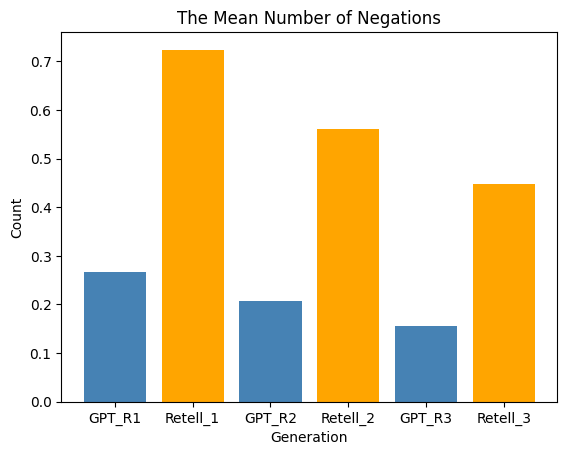

In [59]:
plt.bar(adv['gen'],adv['mean'], color=['steelblue','orange'])
plt.title('The Mean Number of Negations')
plt.xlabel('Generation')
plt.ylabel('Count')

### 1.7. Statistical Test for Ratios

In [60]:
#!pip3 install statsmodels
#Because the values are proportions, I conducted a z-test analysis 
#Because the values are proportions, I conducted a z-test analysis 
for i in range(1, 4):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is not significant with p-value {pvalue}")
        

Z test for GPT_R1 ratio vs. Retell_1 ratio is significant with p-value 0.0020834907450830754
Z test for GPT_R2 ratio vs. Retell_2 ratio is significant with p-value 0.0006181933490244548
Z test for GPT_R3 ratio vs. Retell_3 ratio is significant with p-value 0.0013395350587059724


In [61]:
# Only human

for i in range(1, 3):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'Retell_{i+1}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for Retell_{i} ratio vs. Retell_{i+1} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for Retell_{i} ratio vs. Retell_{i+1} ratio is not significant with p-value {pvalue}")

        
ztest(count_ratio.Retell_1_adv_ratio, count_ratio.Retell_3_adv_ratio, value=0)

Z test for Retell_1 ratio vs. Retell_2 ratio is not significant with p-value 0.6114841683472254
Z test for Retell_2 ratio vs. Retell_3 ratio is not significant with p-value 0.7531194162727526


(-0.1459568815885566, 0.8839554273235474)

In [62]:
# Only GPT

for i in range(1, 3):
    group1 = count_ratio[f'GPT_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i+1}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_{i} ratio vs. GPT_{i+1} ratio is significant with p-value {pvalue}")
    else:
        print(f"Z test for GPT_{i} ratio vs. GPT_{i+1} ratio is not significant with p-value {pvalue}")

        
ztest(count_ratio.GPT_1_adv_ratio, count_ratio.GPT_3_adv_ratio, value=0)

Z test for GPT_1 ratio vs. GPT_2 ratio is not significant with p-value 0.6468943808774712
Z test for GPT_2 ratio vs. GPT_3 ratio is not significant with p-value 0.6732808157525589


(0.8630642885929638, 0.38810212118200726)

### 1.7.1. Visualize Ratios

In [63]:
#Because the values are proportions, I conducted a z-test analysis 

for i in range(1, 4):
    group1 = count_ratio[f'Retell_{i}_adv_ratio']
    group2 = count_ratio[f'GPT_{i}_adv_ratio']
    statistic, pvalue = ztest(x1=group1, x2=group2, value=0)
    if pvalue < 0.05:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is significant with z = {statistic}, p-value {pvalue}")
    else:
        print(f"Z test for GPT_R{i} ratio vs. Retell_{i} ratio is not significant with z = {statistic}, p-value {pvalue}")
        
ratio_means = pd.DataFrame()
ratio_means['mean'] = [*count_ratio.mean()]
ratio_means['gen']= ['GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin','GPT_3', 'GPT_2','GPT_1', 'Retell_1','Retell_2','Retell_3','origin']
ratio_means['type']= ['noun','noun','noun','noun','noun','noun','noun','verb','verb','verb','verb','verb','verb','verb','adj','adj','adj','adj','adj','adj','adj','adv','adv','adv','adv','adv','adv','adv','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','con_det_prep','pron','pron','pron','pron','pron','pron','pron','prep','prep','prep','prep','prep','prep','prep']
adv_ratio = ratio_means[ratio_means.type == 'adv']
adv_ratio = adv_ratio.set_index(['gen']).reindex(['GPT_1', 'Retell_1','GPT_2', 'Retell_2','GPT_3', 'Retell_3']).reset_index()


Z test for GPT_R1 ratio vs. Retell_1 ratio is significant with z = 3.078065557893003, p-value 0.0020834907450830754
Z test for GPT_R2 ratio vs. Retell_2 ratio is significant with z = 3.42350403111364, p-value 0.0006181933490244548
Z test for GPT_R3 ratio vs. Retell_3 ratio is significant with z = 3.207372323255804, p-value 0.0013395350587059724


Text(0, 0.5, 'Ratio')

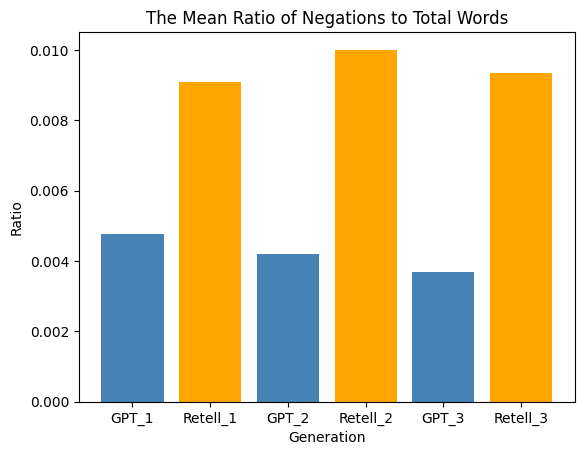

In [64]:
adv_ratio
plt.bar(adv_ratio['gen'],adv_ratio['mean'], color=['steelblue','orange'])
plt.title('The Mean Ratio of Negations to Total Words')
plt.xlabel('Generation')
plt.ylabel('Ratio')

### 1.8. Calculate Verb-Negation Ratio

In [65]:
#Adverb-verb ratio

#For human
for i in range(1,4):
    df[f'Retell_{i}_adv_to_verb_ratio'] = df[f'tokenized_Retell_{i}_tag_adv'] / df[f'tokenized_Retell_{i}_tag_verb']

#For GPT
for i in range(1,4):
    df[f'GPT_{i}_adv_to_verb_ratio'] = df[f'tokenized_GPT_R{i}_tag_adv'] / df[f'tokenized_GPT_R{i}_tag_verb']

# For original story
df['story_adv_to_verb_ratio'] = df['tokenized_STORY_tag_adv'] / df['tokenized_STORY_tag_verb']

In [66]:
# Adverb - Total word count ratio

retell_cols = ['Retell_1', 'Retell_2', 'Retell_3']
gpt_cols = ['GPT_R1', 'GPT_R2', 'GPT_R3']

# For human
for col in retell_cols:
    df[f'{col}_adv_to_all_words'] = df[f'tokenized_{col}_tag_adv'] / (df[f'tokenized_{col}'].apply(lambda x: len(x)))

# For GPT
for col in gpt_cols:
    df[f'{col}_adv_to_all_words'] = df[f'tokenized_{col}_tag_adv'] / (df[f'tokenized_{col}'].apply(lambda x: len(x)))

### 1.8.2. Visualize Negation/Verb

#### 1.8.2.1. Prepare dataset to visualize

In [67]:
verbnoun_ratio = df[['story_adv_to_verb_ratio',
 'Retell_1_adv_to_verb_ratio',
 'Retell_2_adv_to_verb_ratio',
 'Retell_3_adv_to_verb_ratio',
 'GPT_1_adv_to_verb_ratio',
 'GPT_2_adv_to_verb_ratio',
 'GPT_3_adv_to_verb_ratio']]

verbnoun_means = pd.DataFrame()
verbnoun_means['mean'] = [*verbnoun_ratio.mean()]

verbnoun_means['gen'] = ['story','Retell_1','Retell_2','Retell_3','GPT_1','GPT_2','GPT_3']
verbnoun_means['type'] = ['origin','human','human','human','gpt','gpt','gpt']


verbnoun_means = verbnoun_means.set_index(['gen']).reindex(['GPT_1', 'Retell_1','GPT_2', 'Retell_2','GPT_3', 'Retell_3']).reset_index()


Text(0, 0.5, 'Ratio')

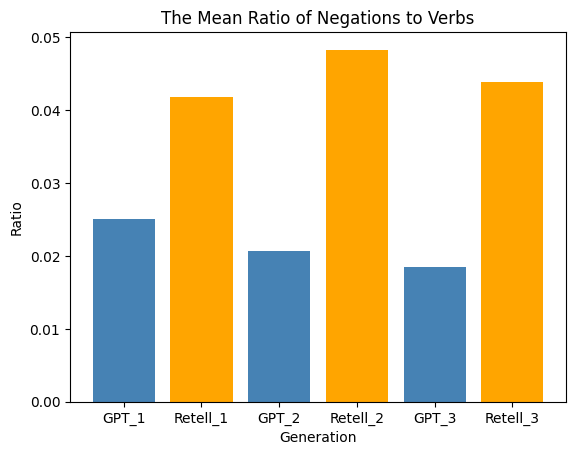

In [68]:
adv_ratio
plt.bar(verbnoun_means['gen'],verbnoun_means['mean'], color=['steelblue','orange'])
plt.title('The Mean Ratio of Negations to Verbs')
plt.xlabel('Generation')
plt.ylabel('Ratio')

## 1.8.1. Statistical Test for Adv/verb  ratios

In [69]:
#Adverb to verb

for i in range(1,4):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_verb_ratio'], x2=df[f'GPT_{i}_adv_to_verb_ratio'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/verb in GPT_R{i}  vs. Retell_{i}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/verb in GPT_R{i}  vs. Retell_{i}  is not significant with p-value {pvalue}")


 Z test for differences in adverb/verb in GPT_R1  vs. Retell_1  is significant with p-value 0.012301729886706478
 Z test for differences in adverb/verb in GPT_R2  vs. Retell_2  is significant with p-value 0.0008071153738456968
 Z test for differences in adverb/verb in GPT_R3  vs. Retell_3  is significant with p-value 0.004666850011276303


In [70]:
# Adverb to total word count
for i in range(1,4):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_all_words'], x2=df[f'GPT_R{i}_adv_to_all_words'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. Retell_{i}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. Retell_{i}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in GPT_R1  vs. Retell_1  is significant with p-value 0.0020834907450830754
 Z test for differences in adverb/all in GPT_R2  vs. Retell_2  is significant with p-value 0.0006181933490244548
 Z test for differences in adverb/all in GPT_R3  vs. Retell_3  is significant with p-value 0.0013395350587059724


### 2. Change in Human Adverb/Verb Ratio ( Negation)

In [71]:
for i in range(1,3):
    zscore,pvalue = ztest(x1=df[f'Retell_{i}_adv_to_all_words'], x2=df[f'Retell_{i+1}_adv_to_all_words'], value=0)
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in Retell_{i}  vs. Retell_{i+1}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in Retell_{i}  vs. Retell_{i+1}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in Retell_1  vs. Retell_2  is not significant with p-value 0.6114841683472254
 Z test for differences in adverb/all in Retell_2  vs. Retell_3  is not significant with p-value 0.7531194162727526


### 2.1. Change in chatGPT Adverb/Verb Ratio ( Negation)

In [72]:
for i in range(1,3):
    zscore,pvalue = ztest(x1=df[f'GPT_R{i}_adv_to_all_words'], x2=df[f'GPT_R{i+1}_adv_to_all_words'], value=0)
    
    if pvalue < 0.05:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. GPT_R{i+1}  is significant with p-value {pvalue}")
    else:
        print(f" Z test for differences in adverb/all in GPT_R{i}  vs. GPT_R{i+1}  is not significant with p-value {pvalue}")

 Z test for differences in adverb/all in GPT_R1  vs. GPT_R2  is not significant with p-value 0.6468943808774712
 Z test for differences in adverb/all in GPT_R2  vs. GPT_R3  is not significant with p-value 0.6732808157525589


# 3. Examine Context of Negations

### 3.1. Example from Highly Negated Sentences 

### Retell 1 

In [96]:
df.sort_values(by='Retell_1_adv_ratio', ascending=False).Retell_1.iloc[0]

"This poor kid didn't know math well, and his teachers and tutors weren't good at teaching.  The kid is trying but he needs more effective educational tools."

In [97]:
df.sort_values(by='Retell_1_adv_ratio', ascending=False).GPT_R1.iloc[0]

'A boy struggled with math and studied hard for an important exam with help from a tutor, sacrificing his video game time. Despite his efforts, he only got a passing grade of 70 and was disappointed.'

### Retell 2

In [91]:
df.sort_values(by='Retell_2_adv_ratio', ascending=False).Retell_2.iloc[3]

"Jessie was very poor and lived in a store front. He wanted to do something with his life, but wasn't sure what. He had a grandmother who had bad health. He didn't own a car and didn't know how to get a ride anywhere, but was wanting to go somewhere and had interest in pursuing a new love life."

In [90]:
df.sort_values(by='Retell_2_adv_ratio', ascending=False).GPT_R2.iloc[3]

'A young man named Jessie found himself alone when Granny left after taking ill. He discovered an abandoned storefront and decided to make it his new home. Jessie watched as people passed by, realizing he had no one looking for him.'

### Retell 3

In [92]:
df.sort_values(by='Retell_3_adv_ratio', ascending=False).Retell_3.iloc[0]

"Frogs like company but don't like summer. They cannot survive outside of water."

In [93]:
df.sort_values(by='Retell_3_adv_ratio', ascending=False).GPT_R3.iloc[0]

'The story is about Hanuxi creatures that are blue, frog-like, and friendly to humans and their kind. They can walk, hop and fly, and live in a water landscape, but do not thrive outside their homes.'